### Laboratorium 4 - zadania

Dany jest zbiór obrazów wraz z etykietami - maskami segmentacji. Twoim zadaniem jest zaproponować metodę binaryzacji obrazów, zaimplementować odpowiednie metryki oceny i wykorzystać je do określenia jakości detekcji w zależności od parametrów metody.

Pytania zadane kursywą możesz traktować jako "zajawki" do sprawozdania.

Dołączony w zadaniu dataset jest podzbiorem datasetu dostępnego w oryginale na portalu [Kaggle](https://www.kaggle.com/longnguyen2306/bacteria-detection-with-darkfield-microscopy).

In [1]:
import os
from typing import Iterator, List, Tuple
from tqdm import tqdm
import cv2
import numpy as np
import matplotlib.pyplot as plt

Do podanego zbioru danych zaimplementowany został poniższy loader. Możesz korzystać z niego albo przez interfejs listy (`loader[3]`) albo przez interfejs iteracyjny (`for sample in loader`). W obu przypadkach zwracana jest para (obraz, etykieta), gdzie obraz jest 3-kanałowym obrazem **RGB** a etykieta 1-kanałowym obrazem o wartościach 0 (tło) i 1 (obiekt-bakteria). Poniższa komórka zawiera przykład.

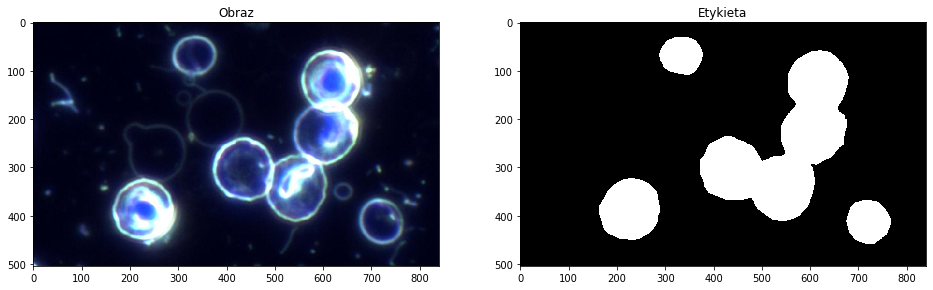

In [2]:
class BacteriaLoader:
    SUBSET = 89, 155
    def __init__(self, root:str, train:bool=True) -> None:
        """
        root (str): path to the folder containing 'images', 'masks' and 'meta.json'
        train (bool): if True, returns the calibration subset, otherwise the validation subset
        """
        image_names = os.listdir(os.path.join(root, 'images'))
        mask_names = os.listdir(os.path.join(root, 'masks'))
        valid_names = self.get_names()
        if any(name not in image_names or name not in mask_names for name in valid_names):
            raise FileNotFoundError("Dataset malformed: files missing.")
        image_names = [os.path.join(root, 'images', file_name) for file_name in valid_names]
        mask_names = [os.path.join(root, 'masks', file_name) for file_name in valid_names]
        test_image_names = image_names[::3]
        train_image_names = [name for name in image_names if name not in test_image_names]
        self.image_names = train_image_names if train else test_image_names
        test_mask_names = mask_names[::3]
        train_mask_names = [name for name in mask_names if name not in test_mask_names]
        self.mask_names = train_mask_names if train else test_mask_names

    def get_names(self) -> List[str]:
        return ['{:03d}.png'.format(i) for i in range(*self.SUBSET)]

    def __getitem__(self, index:int) -> Tuple[np.ndarray, np.ndarray]:
        image = cv2.imread(self.image_names[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask_ = cv2.imread(self.mask_names[index], cv2.IMREAD_GRAYSCALE)
        mask = np.zeros_like(mask_, dtype=np.uint8)
        mask[mask_==1] = 1  # pozostałe obiekty ignorujemy
        return image, mask

    def __len__(self) -> int:
        return len(self.image_names)

    def __iter__(self) -> Iterator[Tuple[np.ndarray, np.ndarray]]:
        for i in range(len(self)):
            yield self[i]


loader = BacteriaLoader('BacteriaKaggle')
image, mask = loader[21]
f, (axi, axm) = plt.subplots(1, 2)
f.set_figwidth(16)
f.set_figheight(8)
axi.imshow(image, interpolation='none');
axi.set_title('Obraz');
axm.imshow(mask*100, interpolation='none', cmap='gray');
axm.set_title('Etykieta');

#### Zadanie 1 (1.0 pkt | 0.5 pkt)

Zaimplementuj w funkcji `detect_bacteria` taki algorytm przetwarzania obrazu, by uzyskać wizualnie akceptowalną binaryzację. Użyj operacji morfologicznych do odfiltrowania artefaktów. Nie staraj się na tym etapie dążyć do idealnych rezultatów - dokładny dobór parametrów algorytmu będzie jednym z następnych kroków.

Do testowania użyj poniższej komórki. Zwróć uwagę na interfejs `**params` - przekazywanie parametrów metody (np. wartości progów, rozmiary kerneli) tą drogą znacznie uprości pracę na dalszych etapach. W razie potrzeby, zapoznaj się z pythonowym mechanizmem [`kwargs`](https://book.pythontips.com/en/latest/args_and_kwargs.html#usage-of-kwargs).

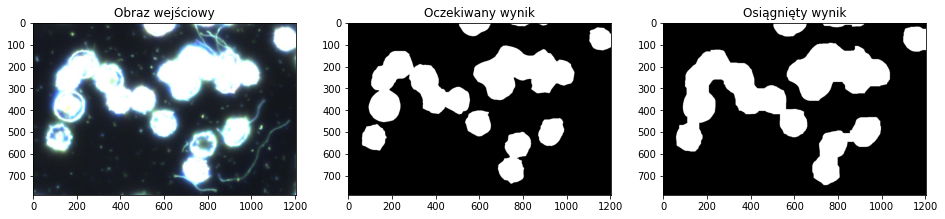

In [6]:
def detect_bacteria(image:np.ndarray, **params) -> np.ndarray:
    # wartości parametrów przekazuj w 'params', np.: params['threshold']

    kernel = np.ones((params["kernel"], params["kernel"]), dtype=np.uint8)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    if params['threshold'] == 'otsu':
        otsu_threshold, threshold_img = cv2.threshold(image,0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    else:
        T, threshold_img = cv2.threshold(image, params["threshold"], 255, cv2.THRESH_BINARY)
    
    output = cv2.morphologyEx(threshold_img, iterations=params["open_iterations"], op=cv2.MORPH_OPEN, kernel=kernel, anchor=params["anchor"], borderType=cv2.BORDER_REPLICATE)
    output = cv2.morphologyEx(output, iterations=params["close_iterations"], op=cv2.MORPH_CLOSE, kernel=kernel, anchor=params["anchor"], borderType=cv2.BORDER_REPLICATE)
    
    return output


dev_image, dev_mask = loader[0] # sprawdź też inne przykłady, np. 9, 37

params = {
    "kernel": 15,
    "anchor": (-1,-1),   
    "open_iterations": 1,
    "close_iterations":2,
    "threshold": 'otsu'
}    

output = detect_bacteria(dev_image, **params)


# wyświetlanie
f, (a_img, a_mask, a_pred) = plt.subplots(1, 3)
f.set_figwidth(16)
f.set_figheight(8)
a_img.imshow(dev_image)
a_img.set_title('Obraz wejściowy');
a_mask.imshow(dev_mask, cmap='gray')
a_mask.set_title('Oczekiwany wynik');
a_pred.imshow(output, cmap='gray')
a_pred.set_title('Osiągnięty wynik');

plt.savefig('zad1.png')

#### Zadanie 2 (1.0 pkt | 0.5 pkt)

Zaimplementuj funkcję `measure` w taki sposób, by wyliczała wybrane przez Ciebie metryki (uwzględnij co najmniej precyzję, czułość, oraz indeks Jaccarda) i zwracała je w formie słownika. Wykorzystaj ją do określenia błędu pomiędzy wynikiem działania twojej funkcji, a maską dla różnych wartości wybranych parametrów (patrz: przykład). Wykonaj testy dla kilku odróżniających się przykładów.  
_Co stanowi przyczynę błędów? Zwróć uwagę na specyfikę obrazów i zasady działania stosowanych algorytmów._

In [7]:
from copy import deepcopy
def run_experiments(params_dict: dict, loader):
    
    iou_values = []
    iou_stds = []
    recall_values = []
    recall_stds = []
    precision_values = []
    precision_stds = []
    
    params_copy = deepcopy(params)
    
    key, value_list = list(params_dict.items())[0]
    for value in tqdm(value_list):
        params_copy[key] = value
        
        iou_cache = []
        recall_cache = []
        precision_cache = []
        for test_image, test_mask in loader:
            output = detect_bacteria(test_image, **params_copy)
            m = measure(output, test_mask)
            iou_cache.append(m['iou'])
            recall_cache.append(m['recall'])
            precision_cache.append(m['precision'])
        
        iou_values.append(np.mean(iou_cache))
        iou_stds.append(np.std(iou_cache))
        
        recall_values.append(np.mean(recall_cache))
        recall_stds.append(np.std(recall_cache))
        
        precision_values.append(np.mean(precision_cache))
        precision_stds.append(np.std(precision_cache))
                        
    fig, ax = plt.subplots(1,3,figsize=(15,10), sharey=True)
#     ax[0].plot(value_list, iou_values, c='r', label='IoU')
    ax[0].errorbar(value_list, iou_values, iou_stds, c='r', marker='^', label='IoU')
    ax[0].legend()
#     ax[1].plot(value_list, precision_values, c='g', label='Precision')
    ax[1].errorbar(value_list, precision_values,precision_stds, c='g', label='Precision')
    ax[1].legend()
#     ax[2].plot(value_list, recall_values, c='b', label='Recall')
    ax[2].errorbar(value_list, recall_values, recall_stds, c='b', label='Recall')
    ax[2].legend()
    plt.title(f'Badanie wpływu parametru: {list(params_dict.keys())[0]}')
    
    
    ax = plt.gca()
    ax.set_ylim([0.0, 1.0])
    plt.legend();
            
            
        

In [51]:
def run_experiments(params_dict: dict, loader):
    
    
    
    
#     key, value_list = list(params_dict.items())[0]
    
    
    fig, ax = plt.subplots(4,1,figsize=(15,10), sharey=True)
    
    
    for row, big_ax in enumerate(ax, start=0):
        big_ax.set_title(f"Badanie wpływu parametru {list(params_dict.keys())[row]}", fontsize=16, pad=20)

        # Turn off axis lines and ticks of the big subplot 
        # obs alpha is 0 in RGBA string!
        big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
        # removes the white frame
        big_ax._frameon = False
        big_ax.set_ylim([0.0, 1.0])


    axes = []
    for i in range(1,13):
        axis = fig.add_subplot(4,3,i)
        if i % 3 == 1:
            title = 'IoU'
        elif i % 3 == 2:
            title = 'Precision'
        elif i % 3 == 0:
            title = 'Recall'
        axis.set_title(title)
        axes.append(axis)
    for i, (key, value_list) in enumerate(list(params_dict.items())):
        params_copy = deepcopy(params)
        iou_values = []
        iou_stds = []
        recall_values = []
        recall_stds = []
        precision_values = []
        precision_stds = []
        for value in tqdm(value_list):
            params_copy[key] = value

            iou_cache = []
            recall_cache = []
            precision_cache = []
            for test_image, test_mask in loader:
                output = detect_bacteria(test_image, **params_copy)
                m = measure(output, test_mask)
                iou_cache.append(m['iou'])
                recall_cache.append(m['recall'])
                precision_cache.append(m['precision'])

            iou_values.append(np.mean(iou_cache))
            iou_stds.append(np.std(iou_cache))

            recall_values.append(np.mean(recall_cache))
            recall_stds.append(np.std(recall_cache))

            precision_values.append(np.mean(precision_cache))
            precision_stds.append(np.std(precision_cache))

    #     ax[0].plot(value_list, iou_values, c='r', label='IoU')
        axes[i * 3].errorbar(value_list, iou_values, iou_stds, c='r', marker='^', label='IoU')
        axes[i * 3].legend()
        axes[i * 3].set_ylim([0.0, 1.0])
    #     ax[1].plot(value_list, precision_values, c='g', label='Precision')
        axes[i * 3 + 1].errorbar(value_list, precision_values,precision_stds, c='g', marker='^', label='Precision')
        axes[i * 3 + 1].legend()
        axes[i * 3 + 1].set_ylim([0.0, 1.0])
    #     ax[2].plot(value_list, recall_values, c='b', label='Recall')
        axes[i * 3 + 2].errorbar(value_list, recall_values, recall_stds, c='b', marker='^', label='Recall')
        axes[i * 3 + 2].legend()
        axes[i * 3 + 2].set_ylim([-0.05, 1.05])
#         ax[i].title(f'Badanie wpływu parametru: {key}')
    
#     for row, big_ax in enumerate(ax, start=0):
#         big_ax.set_title(f"Badanie wpływu parametru {list(params_dict.keys())[row]}", fontsize=16)
#         # Turn off axis lines and ticks of the big subplot 
#         # obs alpha is 0 in RGBA string!
#         big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
#         # removes the white frame
#         big_ax._frameon = False

    
    plt.tight_layout()
    plt.legend();


100%|█████████████████████████████████████████████| 9/9 [00:57<00:00,  6.33s/it]


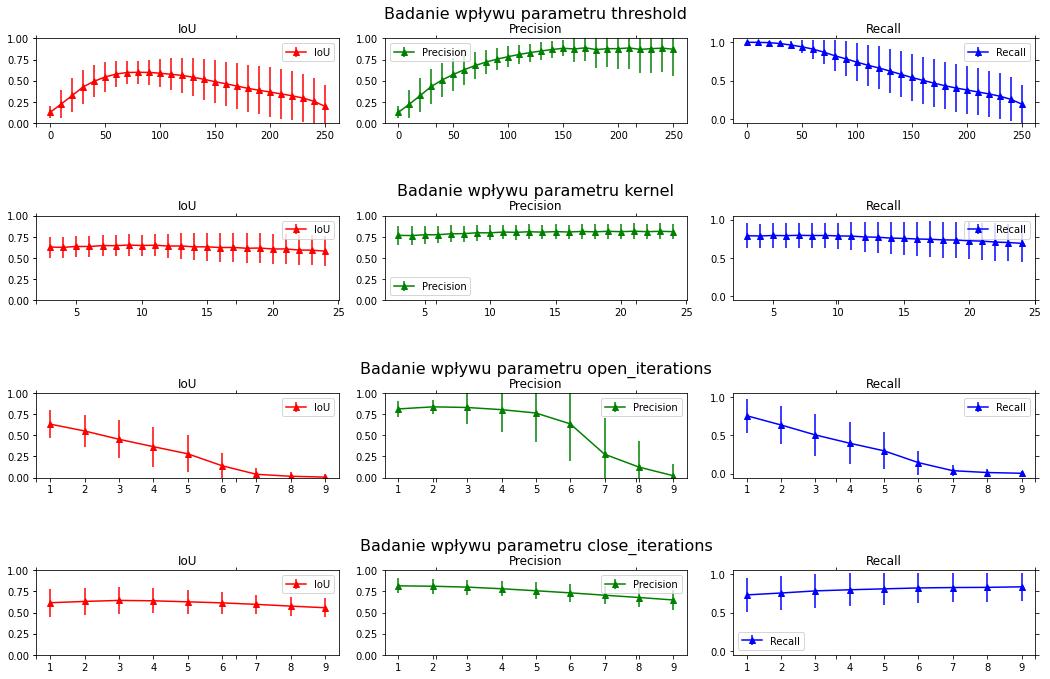

In [52]:
run_experiments({"threshold": list(range(0,260,10)),
                "kernel": list(range(3,25)),
                "open_iterations": list(range(1,10)),
                "close_iterations": list(range(1, 10))}, loader)

plt.savefig('zad2.png')

In [9]:
import sklearn.metrics

def measure(predicted, truth):
    eps = 1e-7
    predicted = predicted / 255
    tn, fp, fn, tp = sklearn.metrics.confusion_matrix(truth.flatten(), predicted.flatten()).ravel()
    tn, fp, fn, tp = np.float64(tn), np.float64(fp), np.float64(fn), np.float64(tp)
    recall = tp / (tp + fn + eps)
    precision = tp / (tp + fp + eps)
    iou = tp / (tp + fp + fn+ eps)
    return {'iou': iou, 'recall': recall, 'precision': precision}

# test_image, test_mask = loader[0]

# param_values = []
# iou_values = []
# recall_values = []
# precision_values = []
# for param_val in range(0, 260, 10):
#     params["threshold"] = param_val
#     output = detect_bacteria(test_image, **params)
#     m = measure(output, test_mask)
#     param_values.append(param_val)
#     iou_values.append(m['iou'])
#     recall_values.append(m['recall'])
#     precision_values.append(m['precision'])
    
# fig, ax = plt.subplots(1,3,figsize=(15,10))
# ax[0].plot(param_values, iou_values, c='r', label='IoU')
# ax[1].plot(param_values, precision_values, c='g', label='Precision')
# ax[2].plot(param_values, recall_values, c='b', label='Recall')

# plt.legend();

In [64]:
len(val_loader)

22

#### Zadanie 3 (1.0 pkt | 0.5 pkt)

Przeanalizuj wpływ wybranych parametrów na średnią jakość predykcji na całym zbiorze testowym. Wybierz na tej podstawie najlepszą kombinację parametrów.  
_Zwracaj uwagę na odchylenie standardowe dla średniej. Czy w zbiorze występują próbki, z którymi Twój algorytm szczególnie sobie nie radzi?_

Jeśli starczy czasu: wykonaj drugą iterację kalibracji w oparciu o wyniki, starając się poprawić binaryzację dla "trudnych" przykładów.

In [61]:
def run_experiments(params_dict: dict, data_loader):
    
#     key, value_list = list(params_dict.items())[0]
    
    
    fig, ax = plt.subplots(4,1,figsize=(15,10), sharey=True)
    
    
    for row, big_ax in enumerate(ax, start=0):
        big_ax.set_title(f"Badanie wpływu parametru {list(params_dict.keys())[row]}", fontsize=16, pad=20)

        # Turn off axis lines and ticks of the big subplot 
        # obs alpha is 0 in RGBA string!
        big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
        # removes the white frame
        big_ax._frameon = False
        big_ax.set_ylim([0.0, 1.0])


    axes = []
    for i in range(1,13):
        axis = fig.add_subplot(4,3,i)
        if i % 3 == 1:
            title = 'IoU'
        elif i % 3 == 2:
            title = 'Precision'
        elif i % 3 == 0:
            title = 'Recall'
        axis.set_title(title)
        axes.append(axis)
        
    worst_cases_all = []
    for i, (key, value_list) in enumerate(list(params_dict.items())):
        params_copy = deepcopy(params)
        iou_values = []
        iou_stds = []
        recall_values = []
        recall_stds = []
        precision_values = []
        precision_stds = []
        for value in tqdm(value_list):
            params_copy[key] = value

            iou_cache = []
            recall_cache = []
            precision_cache = []
            for test_image, test_mask in data_loader:
                output = detect_bacteria(test_image, **params_copy)
                m = measure(output, test_mask)
                iou_cache.append(m['iou'])
                recall_cache.append(m['recall'])
                precision_cache.append(m['precision'])
                
            
            worst_cases_all.append(np.argmin(iou_cache))
            iou_values.append(np.mean(iou_cache))
            iou_stds.append(np.std(iou_cache))

            recall_values.append(np.mean(recall_cache))
            recall_stds.append(np.std(recall_cache))

            precision_values.append(np.mean(precision_cache))
            precision_stds.append(np.std(precision_cache))

    #     ax[0].plot(value_list, iou_values, c='r', label='IoU')
        axes[i * 3].errorbar(value_list, iou_values, iou_stds, c='r', marker='^', label='IoU')
        axes[i * 3].legend()
        axes[i * 3].set_ylim([0.0, 1.0])
    #     ax[1].plot(value_list, precision_values, c='g', label='Precision')
        axes[i * 3 + 1].errorbar(value_list, precision_values,precision_stds, c='g', marker='^', label='Precision')
        axes[i * 3 + 1].legend()
        axes[i * 3 + 1].set_ylim([0.0, 1.0])
    #     ax[2].plot(value_list, recall_values, c='b', label='Recall')
        axes[i * 3 + 2].errorbar(value_list, recall_values, recall_stds, c='b', marker='^', label='Recall')
        axes[i * 3 + 2].legend()
        axes[i * 3 + 2].set_ylim([-0.05, 1.05])
#         ax[i].title(f'Badanie wpływu parametru: {key}')
    
#     for row, big_ax in enumerate(ax, start=0):
#         big_ax.set_title(f"Badanie wpływu parametru {list(params_dict.keys())[row]}", fontsize=16)
#         # Turn off axis lines and ticks of the big subplot 
#         # obs alpha is 0 in RGBA string!
#         big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
#         # removes the white frame
#         big_ax._frameon = False

    
    plt.tight_layout()
    plt.legend();
    return worst_cases_all

In [62]:
val_loader = BacteriaLoader(root='BacteriaKaggle', train=False)

100%|█████████████████████████████████████████████| 9/9 [00:30<00:00,  3.39s/it]


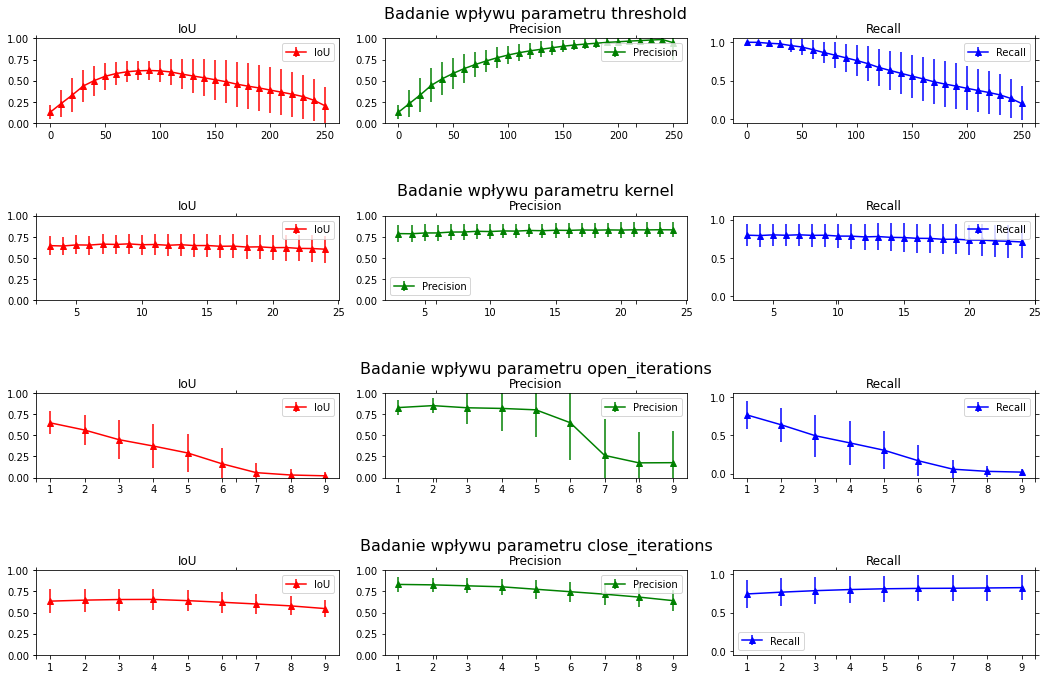

In [63]:
worst_cases = run_experiments({"threshold": list(range(0,260,10)),
                "kernel": list(range(3,25)),
                "open_iterations": list(range(1,10)),
                "close_iterations": list(range(1, 10))}, val_loader)

plt.savefig('zad3.png')

In [60]:
print(worst_cases)

[7, 18, 18, 21, 21, 21, 21, 21, 21, 9, 9, 11, 11, 11, 11, 11, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 9, 9, 9, 9, 9, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 5, 5, 5, 2, 2, 2, 2, 9, 9, 9, 9, 9, 7, 7, 7, 7]


[(9, 30), (14, 9), (21, 6), (7, 5), (11, 5), (2, 4), (5, 3), (18, 2), (15, 1), (8, 1)]


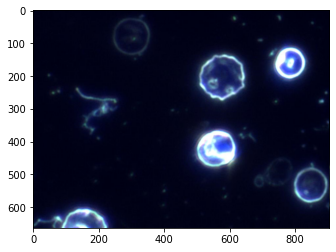

In [72]:
from collections import Counter

b = Counter(worst_cases)
print(b.most_common(10))


plt.imshow(val_loader[9][0])

In [68]:
def run_experiments(params_dict: dict, loader, indexes):
    
    
    
    
#     key, value_list = list(params_dict.items())[0]
    
    
    fig, ax = plt.subplots(4,1,figsize=(15,10), sharey=True)
    
    
    for row, big_ax in enumerate(ax, start=0):
        big_ax.set_title(f"Badanie wpływu parametru {list(params_dict.keys())[row]}", fontsize=16, pad=20)

        # Turn off axis lines and ticks of the big subplot 
        # obs alpha is 0 in RGBA string!
        big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
        # removes the white frame
        big_ax._frameon = False
        big_ax.set_ylim([0.0, 1.0])


    axes = []
    for i in range(1,13):
        axis = fig.add_subplot(4,3,i)
        if i % 3 == 1:
            title = 'IoU'
        elif i % 3 == 2:
            title = 'Precision'
        elif i % 3 == 0:
            title = 'Recall'
        axis.set_title(title)
        axes.append(axis)
    for i, (key, value_list) in enumerate(list(params_dict.items())):
        params_copy = deepcopy(params)
        iou_values = []
        iou_stds = []
        recall_values = []
        recall_stds = []
        precision_values = []
        precision_stds = []
        for value in tqdm(value_list):
            params_copy[key] = value

            iou_cache = []
            recall_cache = []
            precision_cache = []
            for index in indexes:
                test_image, test_mask = loader[index]
#             for test_image, test_mask in loader:
                output = detect_bacteria(test_image, **params_copy)
                m = measure(output, test_mask)
                iou_cache.append(m['iou'])
                recall_cache.append(m['recall'])
                precision_cache.append(m['precision'])

            iou_values.append(np.mean(iou_cache))
            iou_stds.append(np.std(iou_cache))

            recall_values.append(np.mean(recall_cache))
            recall_stds.append(np.std(recall_cache))

            precision_values.append(np.mean(precision_cache))
            precision_stds.append(np.std(precision_cache))

    #     ax[0].plot(value_list, iou_values, c='r', label='IoU')
        axes[i * 3].errorbar(value_list, iou_values, iou_stds, c='r', marker='^', label='IoU')
        axes[i * 3].legend()
        axes[i * 3].set_ylim([0.0, 1.0])
    #     ax[1].plot(value_list, precision_values, c='g', label='Precision')
        axes[i * 3 + 1].errorbar(value_list, precision_values,precision_stds, c='g', marker='^', label='Precision')
        axes[i * 3 + 1].legend()
        axes[i * 3 + 1].set_ylim([0.0, 1.0])
    #     ax[2].plot(value_list, recall_values, c='b', label='Recall')
        axes[i * 3 + 2].errorbar(value_list, recall_values, recall_stds, c='b', marker='^', label='Recall')
        axes[i * 3 + 2].legend()
        axes[i * 3 + 2].set_ylim([-0.05, 1.05])
#         ax[i].title(f'Badanie wpływu parametru: {key}')


    
    plt.tight_layout()
    plt.legend();

100%|█████████████████████████████████████████████| 9/9 [00:05<00:00,  1.76it/s]


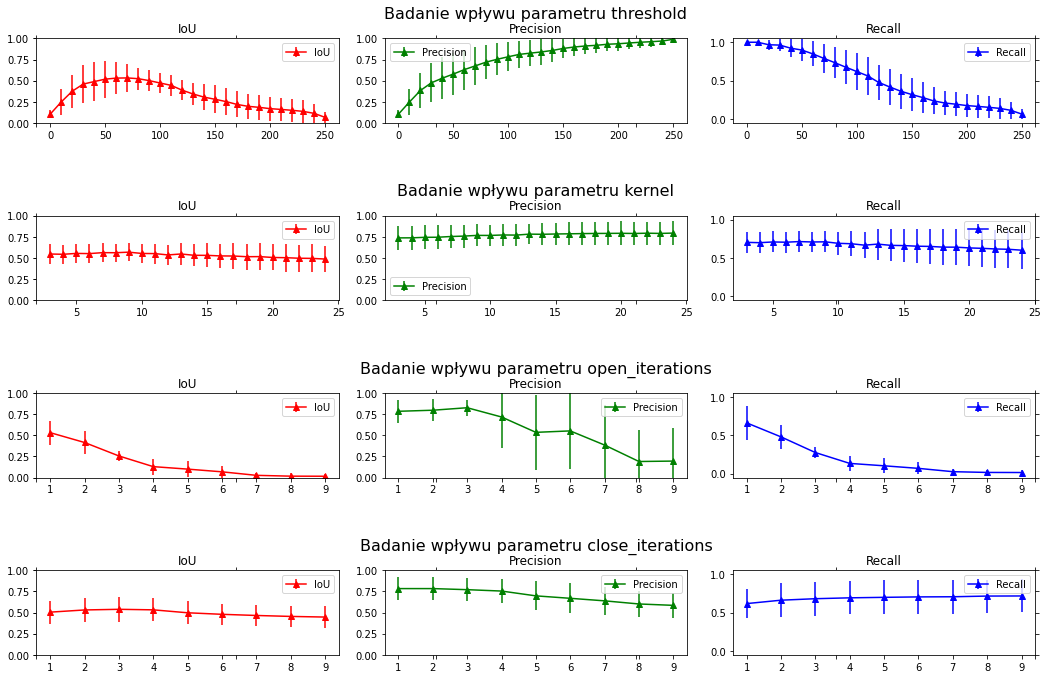

In [73]:
worst_indexes = [9, 14, 21, 7, 11] 
# , 2, 5, 18, 15, 8]

run_experiments({"threshold": list(range(0,260,10)),
                "kernel": list(range(3,25)),
                "open_iterations": list(range(1,10)),
                "close_iterations": list(range(1, 10))}, val_loader, worst_indexes)

plt.savefig('zad3v2.png')

100%|███████████████████████████████████████████| 26/26 [01:10<00:00,  2.72s/it]


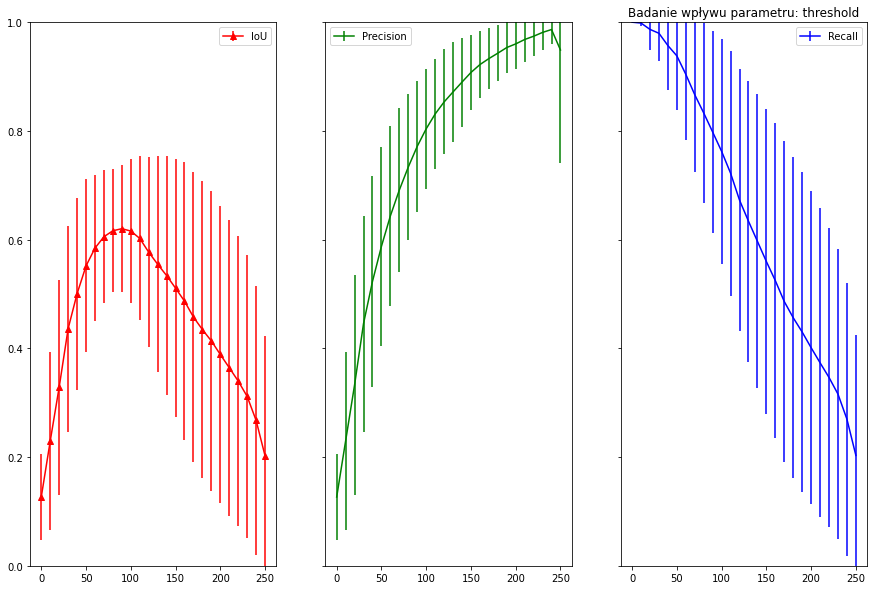

In [57]:
run_experiments({"threshold": list(range(0,260,10))}, val_loader)

100%|███████████████████████████████████████████| 22/22 [01:01<00:00,  2.81s/it]


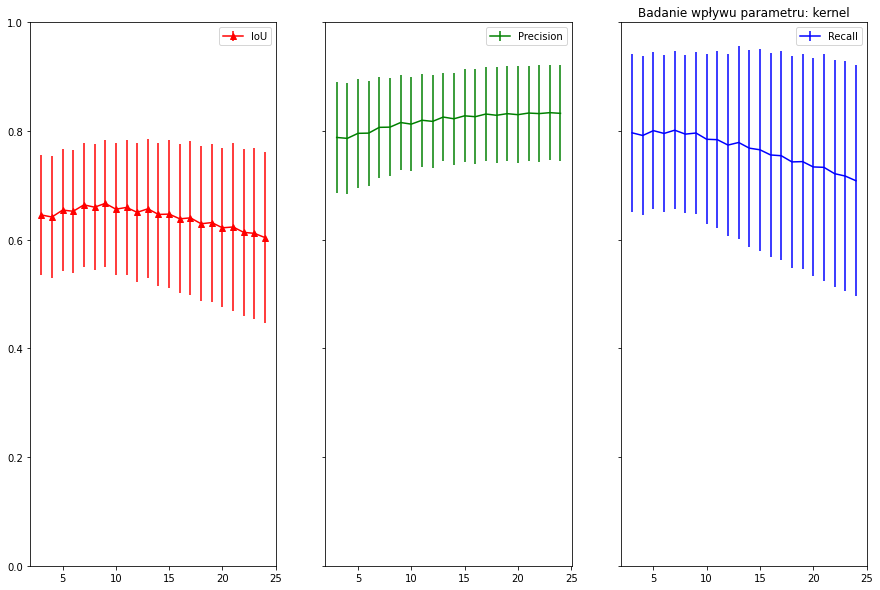

In [58]:
run_experiments({"kernel": list(range(3,25))}, val_loader)

In [74]:
params = {
    "kernel": 14,
    "anchor": (-1,-1),   
    "open_iterations": 1,
    "close_iterations": 4,
    "threshold": 90
}    

def test_run(params_dict: dict, train_loader, val_loader):
    
    train_iou = 0
    train_precision = 0
    train_recall = 0
    
    val_iou = 0
    val_precision = 0
    val_recall = 0
    
    iou_cache = []
    recall_cache = []
    precision_cache = []
    for test_image, test_mask in train_loader:
        output = detect_bacteria(test_image, **params_dict)
        m = measure(output, test_mask)
        iou_cache.append(m['iou'])
        recall_cache.append(m['recall'])
        precision_cache.append(m['precision'])

        
    train_iou = np.mean(iou_cache)
    train_precision = np.mean(precision_cache)
    train_recall = np.mean(recall_cache)
    
    iou_cache = []
    recall_cache = []
    precision_cache = []
    for test_image, test_mask in val_loader:
        output = detect_bacteria(test_image, **params_dict)
        m = measure(output, test_mask)
        iou_cache.append(m['iou'])
        recall_cache.append(m['recall'])
        precision_cache.append(m['precision'])

        
    val_iou = np.mean(iou_cache)
    val_precision = np.mean(precision_cache)
    val_recall = np.mean(recall_cache)
    
    print(f'TRAIN -  IoU {train_iou} - Precision {train_precision} - Recall {train_recall}')
    print(f'VAL -  IoU {val_iou} - Precision {val_precision} - Recall {val_recall}')
    
    

#### Zadanie 4 (0.0 pkt | 0.5 pkt)

Przetestuj działanie tak skalibrowanego algorytmu na zbiorze walidacyjnym.  
_Jak wyniki mają się do tych ze zbioru kalibracyjnego? Dlaczego?_

In [75]:
val_loader = BacteriaLoader(root='BacteriaKaggle', train=False)

In [76]:
test_run(params, loader, val_loader)

TRAIN -  IoU 0.5944482018074784 - Precision 0.7136252907502574 - Recall 0.8232638782528034
VAL -  IoU 0.6166927316273916 - Precision 0.7374304139375781 - Recall 0.8300318904809747


In [77]:
params = {
    "kernel": 10,
    "anchor": (-1,-1),   
    "open_iterations": 1,
    "close_iterations": 4,
    "threshold": 50
}  

test_run(params, loader, val_loader)

TRAIN -  IoU 0.5214295666162921 - Precision 0.5417687215948153 - Recall 0.9574734090974423
VAL -  IoU 0.5287159553053715 - Precision 0.5568859742159772 - Recall 0.9502678022595495
